# Activity 2.1. Linear Regression
## Introduction
In this activity you learn how to use an optimization algorithm, called Stochastic Gradient Descent (SGD), to build a linear model for regression. In Activity 2, you will be asked to expand the linear regression implementation and develop ridge regression algorithm (linear regression with $\ell_2$ regularization).

## Instructions
<ol>
	<li>Generate a synthetic dataset suitable for regression and divide it to train and test sets,
    <li>Choose and implement a basis function $\pmb{\phi}$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and termination threshold $\epsilon$.</li>
	<li> Use the above function and repeat the following until the difference between the old and new weight vectors becomes small (i.e., $d(\pmb{w}^{\tau+1}, \pmb{w}^{\tau}) \leq\epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}.\pmb{\phi}_n) \pmb{\phi}_n$</li>
</ol>
</li>
</ol>
</li>
	<li>Plot the weights $\pmb{w}^{\tau}$ vs. iteration number $\tau$</li>
    <li>Plot the training and testing errors vs. iteration number $\tau$.</li>
    <li>Repeat the above experiments using different datasets, random seeds, initial weights, and $\epsilon$ value</li>
</ol>

## Implementation
### Dataset
Let start with loading libraries and generateing a synthetic dataset, as follows. Here, we generate $N$ data points generated uniformly at random (using `runif`). We then choose a weight vector (called `coeff`) using which we produce the corresponding target value for each data point.  In the training time, we pretend that we don't know the weight vector and we try to learn it using the generated training dataset.

Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'reshape2' was built under R version 3.4.4"

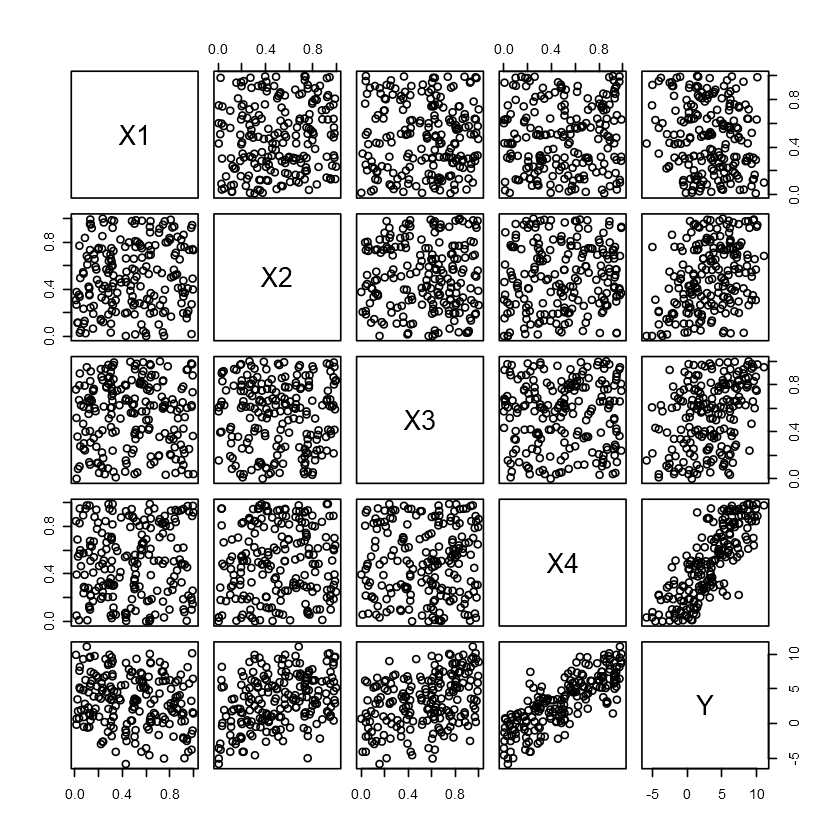

In [1]:
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions
set.seed(1234) # to make the results of stochastic methods reproducible

# geberate N x D data samples
N <- 200 # number of all data point (test and train)
D <- 4 # number of features/attributes
data <- data.frame(matrix(runif(D*N), nrow=N, ncol=D))

# generate the labels
coeff <- matrix(c(-5,-3,4,5,10), nrow = D+1, ncol = 1) # the real coefficient to be estimated

# add a column to the data frame labelled 'Y'. Operator %*% is matrix product.
# We thus generate a linear target variable over the 4 attributes using the
# polynomial (x0, x1, x2, x3, x4) coefficients.
data <- cbind(data, 'Y'=as.matrix(cbind(1, data[, 1:D])) %*% coeff)

# add gaussian noise to the labels (just to make it a little bit more challenging)
data$Y <- data$Y + rnorm(N, mean = 0, sd =1)
pairs(data)

Now, divide the dataset into testing and training sets

In [2]:
# divide data into training and testing sets
train.len <- N/2
train.index <- sample(1:N, train.len)
train.data <- data[train.index,  1:D]
train.label <- data[train.index, 'Y']
test.data <- data[-train.index, 1:D]
test.label <- data[-train.index, 'Y']

## Implementation
Now, based on the instruction, we initialize the parameter values.

### Auxilary Functions
To produce a clean and readable code, let us first define some auxiliary function that calculate the prediction and cost based on the projected data and estimated coefficients.

In [3]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w) {
    return(Phi %*% w)
} 

# auxiliary function to calculate a cost function.
# This implements the formula \sum_{n=1}^N [t_n - w_n . \phi(x_n)]^2
error_func <- function (Phi, w, label) {
    return( sum((predict_func(Phi, w) - label)^2) / 2 )
}

### Initialization

In [4]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0

T <- train.label # rename just for convenience
tau.max <- 10000 # maximum number of iterations
eta <- 0.01      # learning rate
epsilon <- 0.1 * mean(T)  # a threshold on the cost (to terminate the process)

W <- matrix(, nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)

error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

### Main Loop

In [5]:
while(!terminate) {
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,], T) <= epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len) {
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,], T) <= epsilon) {terminate <- TRUE; break}
        
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient:
            W[(tau+1), j] <- W[tau, j] + eta * (T[i] - t_pred) * Phi[i, j]
        }
        
        # record the error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,], train.label)
        error[tau, 'test']  <- error_func(as.matrix(cbind(1, test.data)),  W[tau,], test.label)
        
        # update the counter:
        tau <- tau + 1        
    }
}

In [6]:
dim(error)
head(error)

[1] 10000     3

tau,train,test
1,943.9298,870.9686
2,972.4638,901.3636
3,976.8306,905.9355
4,968.1641,896.8447
5,966.4885,895.0860
6,955.4284,883.5738


In [7]:
error.m <- melt(error[1:tau,], id='tau')
dim(error.m)
head(error.m)

# the final result is:
w <- W[tau,]
cat('The  real coefficents are:', coeff, '\nThe  final coefficents are:', w)

[1] 20000     3

tau,variable,value
1,train,943.9298
2,train,972.4638
3,train,976.8306
4,train,968.1641
5,train,966.4885
6,train,955.4284


The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.922834 -3.322868 4.27025 4.820343 9.94146

### Visualizations

  Let's plot the errors of the learned weight vectors over the training iterations on the training and test sets.

Warning message:
"Removed 2 rows containing missing values (geom_path)."

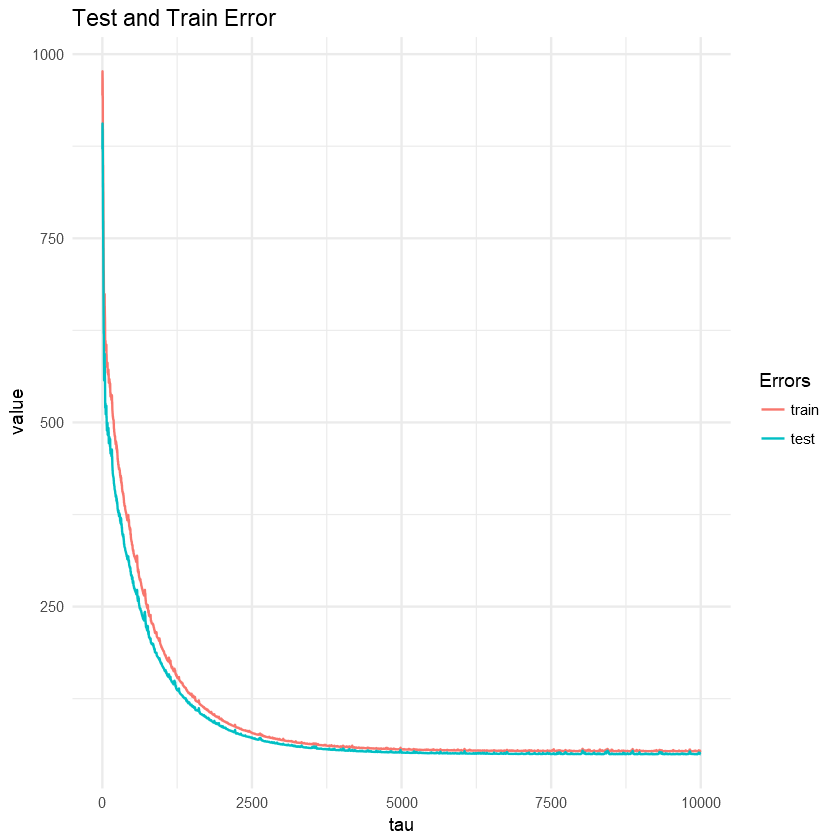

In [8]:
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) + theme_minimal()
  

Now let's plot the elements of the learned weight vectors over the training iterations.

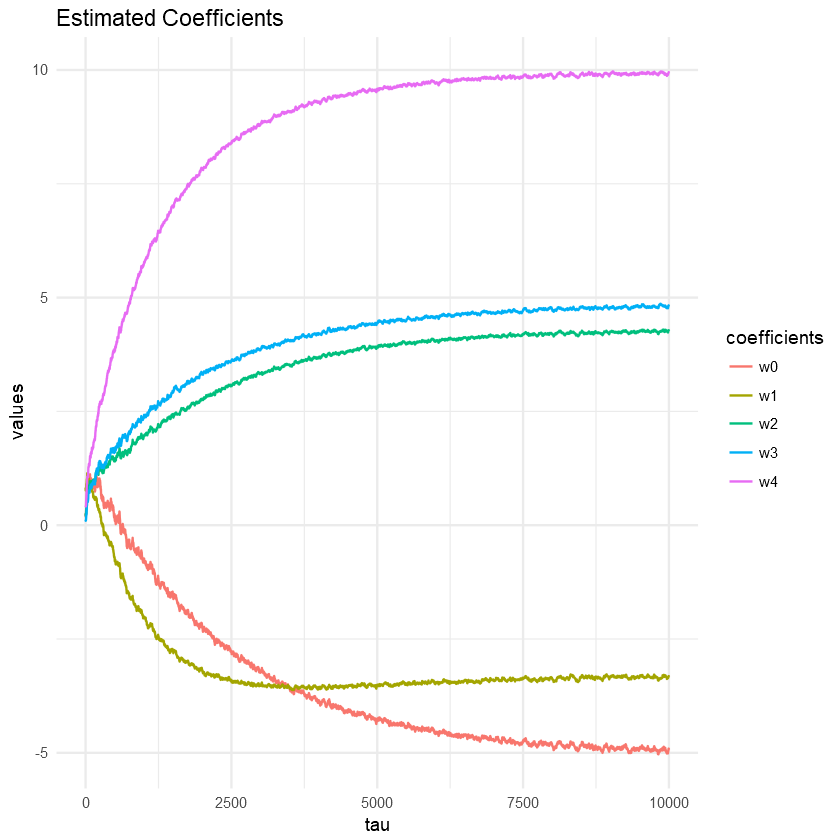

In [9]:
W.m <- as.data.frame(W); names(W.m) <- c('w0','w1','w2','w3','w4')
W.m$tau <- 1:nrow(W)
W.m <- melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()

## Discussions
<ol>

	<li>How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.</li>
	<li>Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around? Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for different values of $a$ and $b$).</li>
	<li>Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training data, but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss the convergence rates and final training error for SGD and batch GD. </li>
</ol>

### Question 1

In [50]:
# Question 1 - test algorithm over a set of learning rates
eta_list <- c(0.002, 0.05, 0.1, 0.3, 0.7)

# initialise a list to store a grid of plots
# see https://stackoverflow.com/questions/28549080/ggplot2-printing-multiple-plots-in-one-page-with-a-loop
pltList <- list()
cat('\nThe  real coefficents are:', coeff)

# calculate coefficients, errors and generate plots for each value of eta
for (k in seq_along(eta_list)) {
    # initialisation
    eta <- eta_list[k]
    W <- matrix(, nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
    W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)
    error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration
    tau <- 1 # iteration counter
    terminate <- FALSE
    
    while(!terminate) {
        # check termination criteria:
        terminate <- tau >= tau.max | error_func(Phi, W[tau,], T) <= epsilon
    
        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        Phi <- Phi[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:train.len) {
            # check termination criteria:
            if (tau >= tau.max | error_func(Phi, W[tau,], T) <= epsilon) {terminate <- TRUE; break}

            t_pred = predict_func(Phi[i,], W[tau,])
            # for each coefficient:
            for (j in 1: ncol(W)){
                # update the coefficient:
                W[(tau+1), j] <- W[tau, j] + eta * (T[i] - t_pred) * Phi[i, j]
            }

            # record the error:
            error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,], train.label)
            error[tau, 'test']  <- error_func(as.matrix(cbind(1, test.data)),  W[tau,], test.label)

            # update the counter:
            tau <- tau + 1        
        }
    }
    
    # final error results
    error.m <- melt(error[1:tau,], id='tau')

    # the final result is:
    w <- W[tau,]
    cat('\nLearning rate eta = ', eta)
    cat('\nThe  final coefficents are:', w)
    
    # plot errors by iteration
    pltList[[2*(k-1) + 1]] <- ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
        geom_line() + ggtitle(paste("Train and Test Error, eta = ", eta)) +
        theme(plot.title = element_text(size=10)) +
        scale_color_discrete(guide = guide_legend(title = 'Errors')) +
        theme(legend.text = element_text(size=8)) #+ theme_minimal()
    
    # plot convergence of coefficients
    W.m <- as.data.frame(W); names(W.m) <- c('w0','w1','w2','w3','w4')
    W.m$tau <- 1:nrow(W)
    W.m <- melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
    pltList[[2*k]] <- ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + 
        geom_line() + ggtitle(paste("Estimated Coefficients, eta = ", eta)) + 
        theme(plot.title = element_text(size=10)) +
        theme(legend.text = element_text(size=8)) #+ theme_minimal()
}


The  real coefficents are: -5 -3 4 5 10
Learning rate eta =  0.002
The  final coefficents are: 0.8736672 0.2953148 1.093193 1.487412 2.239349
Learning rate eta =  0.05
The  final coefficents are: -4.105089 -3.354534 4.025276 4.538894 9.666195
Learning rate eta =  0.1
The  final coefficents are: -4.542342 -3.215071 4.381874 4.862331 10.08492
Learning rate eta =  0.3
The  final coefficents are: -4.46596 -3.280655 4.746363 4.764779 10.68165
Learning rate eta =  0.7
The  final coefficents are: -3.211119 -3.362666 5.893163 4.38229 14.13152

Warning message:
"Removed 2 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_path)."

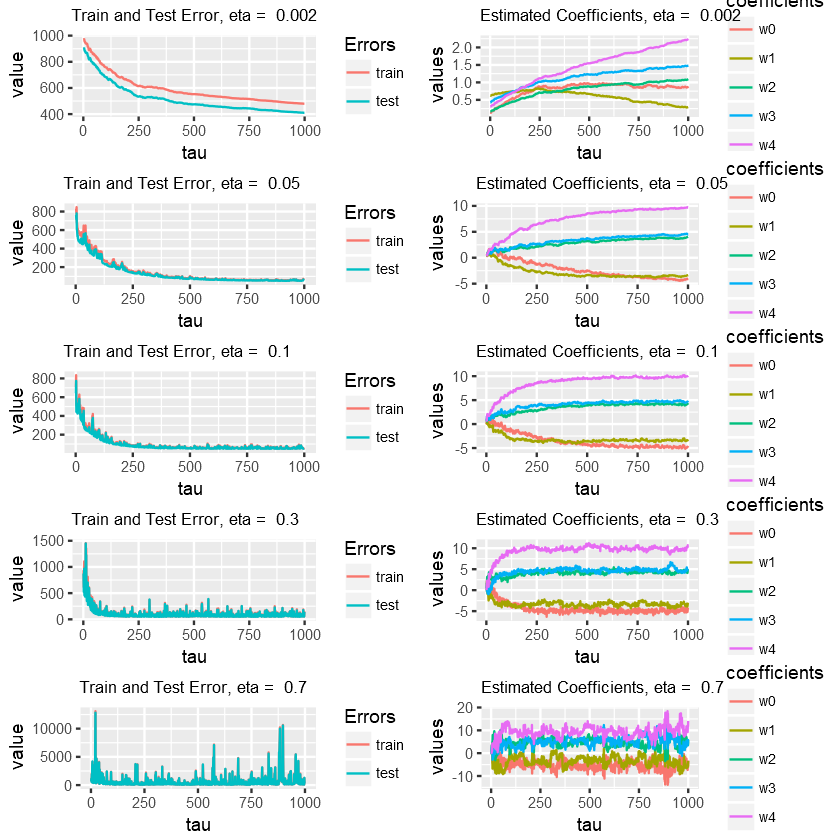

In [51]:
# print grid of plots to screen
library(gridExtra) # for grid.arrange
library(grid)
#do.call(grid.arrange, c(pltList[1:length(pltList)],
#        list(ncol=2, top=textGrob("Error Evolution and Convergence of Coefficients"))))

grid.arrange(grobs = pltList, ncol=2)

In [ ]:
# to overcome above error, do following at command line:
# $jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
# if crashes, try a smaller number e.g. 1.0e9

### Question 2

In [30]:
# Question 2 - Implement a variable learing rate eta
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0

T <- train.label         # rename just for convenience
tau.max <- 1000          # maximum number of iterations
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

# parameters to control value of learning rate eta defined below
a <- 50
b <- 50

W <- matrix(, nrow=tau.max, ncol=ncol(Phi))  # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi))  # initial weight (any better idea?)

error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

while(!terminate) {
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,], T) <= epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len) {
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,], T) <= epsilon) {terminate <- TRUE; break}
        
        t_pred = predict_func(Phi[i,], W[tau,])
        eta <- a /(tau + b)   # set learning rate to decrease with increasing iterations
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient:
            W[(tau+1), j] <- W[tau, j] + eta * (T[i] - t_pred) * Phi[i, j]
        }
        
        # record the error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,], train.label)
        error[tau, 'test']  <- error_func(as.matrix(cbind(1, test.data)),  W[tau,], test.label)
        
        # update the counter:
        tau <- tau + 1        
    }
}

In [31]:
error.m <- melt(error[1:tau,], id='tau')
dim(error.m)
head(error.m)

# the final result is:
w <- W[tau,]
cat('The  real coefficents are:', coeff, '\nThe  final coefficents are:', w)

[1] 2000    3

tau,variable,value
1,train,784.2306
2,train,715.1392
3,train,2807.9590
4,train,793.7846
5,train,764.3743
6,train,972.3728


The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -5.101634 -3.27229 4.247764 4.832837 9.921644

Warning message:
"Removed 2 rows containing missing values (geom_path)."

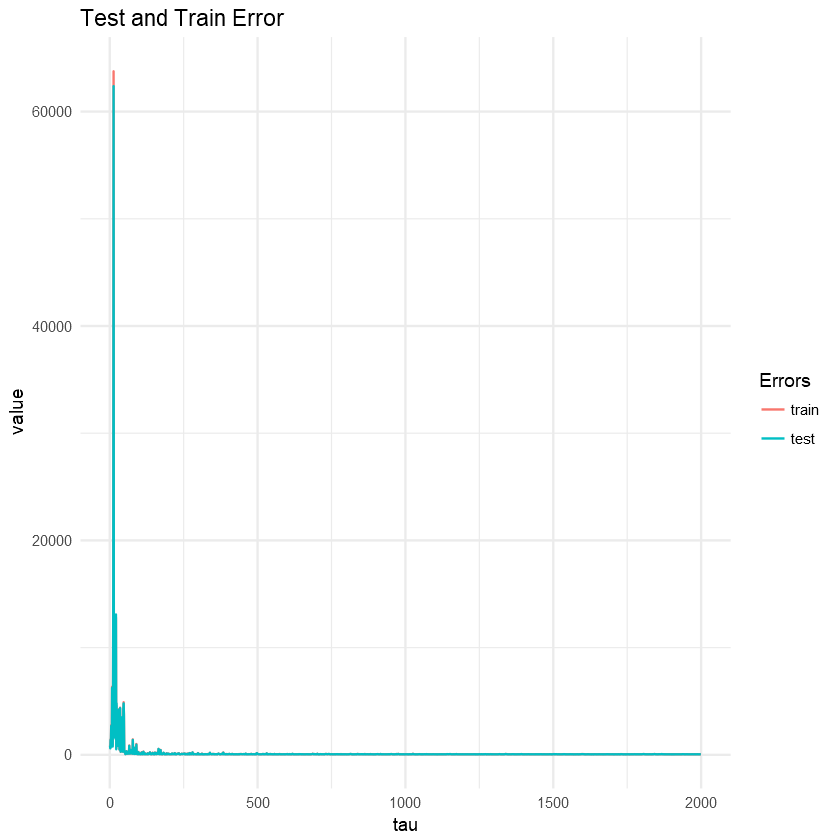

In [22]:
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) + theme_minimal()


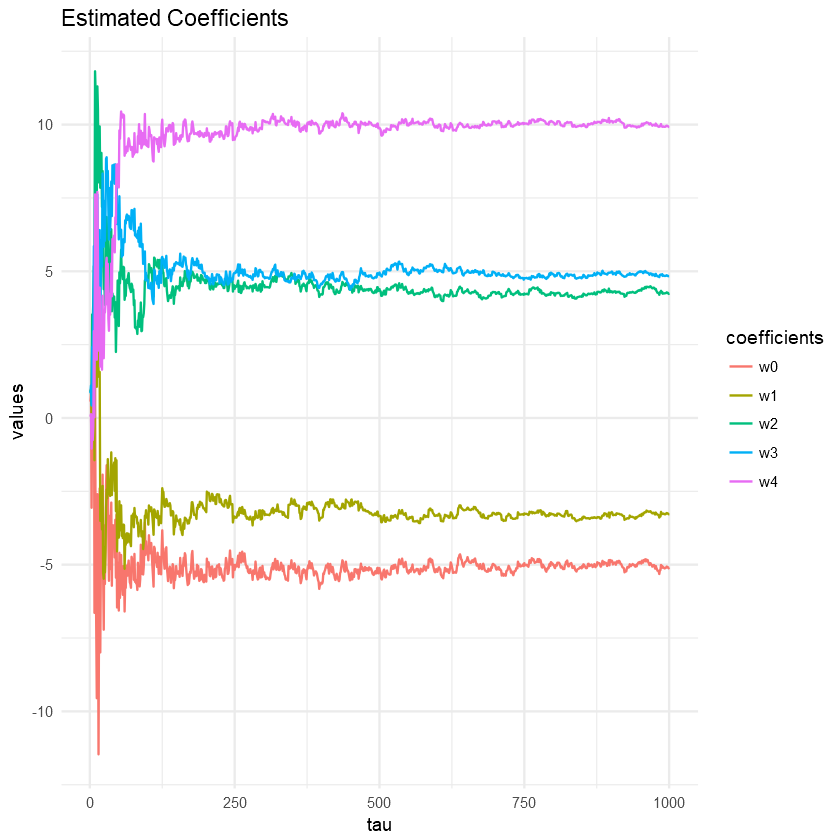

In [32]:
W.m <- as.data.frame(W); names(W.m) <- c('w0','w1','w2','w3','w4')
W.m$tau <- 1:nrow(W)
W.m <- melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()

For small values of learning rate parameters $a$ and $b$, e.g. of order 1, the learning rate $\eta$ becomes very small after a many iterations, and the coefficients are not able to converge to their expected values.  For moderate values of $a$ and $b$, with them being about equal, we initially get a learning rate around $\eta \sim 1$, but it eventually becomes small enough to narrow in on the solution without being too small.  Learning becomes much faster than with a fixed value of $\eta = 0.01$.

In [18]:
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0

T <- train.label # rename just for convenience
tau.max <- 10000 # maximum number of iterations
eta <- 0.1       # learning rate
epsilon <- 0.1 * mean(T)  # a threshold on the cost (to terminate the process)

W <- matrix(, nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)

error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1  # iteration counter
error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,], train.label)
error[tau, 'test']  <- error_func(as.matrix(cbind(1, test.data)),  W[tau,], test.label)
terminate <- FALSE

j <- 3
#Phi
#Phi[, j]
#W[tau,]
t_pred <- predict_func(Phi, W[tau,])
W[(tau+1), j] <- W[tau, j] + eta * sum((T - t_pred) * Phi[, j])
W[(tau+1), j]
error[tau,]

[1] 11.93561

tau,train,test
1,837.457,753.3681


In [7]:
# Q3 - Implement the batch gradient descent algorithm

##### Initialisation
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0
T <- train.label # rename just for convenience

# algorithm parameters
tau.max <- 100 # maximum number of iterations
eta <- 0.1       # learning rate
epsilon <- 0.001 * mean(T)  # a threshold on the cost (to terminate the process)

# coefficient and error matrices
W <- matrix(, nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)
error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1  # iteration counter
terminate <- FALSE

# calculate error of first iteration
error[tau, 'train'] <- error_func(Phi, W[tau,], T)
error[tau, 'test']  <- error_func(as.matrix(cbind(1, test.data)), W[tau,], test.label)

cat("epsilon =", epsilon, "\n")
##### Main loop
while(!terminate) {
    # check termination criteria:
    cat("\ntau =", tau, "\n")
    cat("W[tau,] =", W[tau,], "\n")
    cat("error =", error[tau, 'train'], "\n")
    terminate <- tau >= tau.max-1 | error[tau, 'train'] <= epsilon
    print(terminate)
    eta_p <- eta  # adaptive eta value
      
    # calculate prediction for current iteration coefficient
    t_pred <- predict_func(Phi, W[tau,])
    while (eta_p > epsilon) {
        for (j in 1: ncol(W)){
            # update the coefficient:
            W[(tau+1), j] <- W[tau, j] + eta_p * sum((T - t_pred) * Phi[, j])
        }
        
        cat("eta_p =", eta_p, "\n")
        cat("W[tau+1,] =", W[tau+1,], "\n")
        # calculate the error:
        error[tau+1, 'train'] <- error_func(Phi, W[tau+1,], T)
        cat("E(tau) =", error[tau, 'train'], "; E(tau+1) =", error[tau+1, 'train'], "\n")
        if (error[tau+1, 'train'] < error[tau, 'train']) {break}
        eta_p <- eta_p / 2
    }
    
    # record the test error for new coefficient
    error[tau+1, 'test']  <- error_func(as.matrix(cbind(1, test.data)),  W[tau+1,], test.label)
    
    # update the counter:
    tau <- tau + 1                
}

epsilon = 0.003239219 

tau = 1 
W[tau,] = 0.652113 0.4587357 0.8416628 0.6954136 0.2684263 
error = 770.5175 
[1] FALSE
eta_p = 0.1 
W[tau+1,] = 14.781 4.029442 10.93596 11.92693 16.27564 
E(tau) = 770.5175 ; E(tau+1) = 58257.88 
eta_p = 0.05 
W[tau+1,] = 7.716555 2.244089 5.888812 6.311171 8.272033 
E(tau) = 770.5175 ; E(tau+1) = 13400.74 
eta_p = 0.025 
W[tau+1,] = 4.184334 1.351412 3.365237 3.503292 4.27023 
E(tau) = 770.5175 ; E(tau+1) = 3057.263 
eta_p = 0.0125 
W[tau+1,] = 2.418223 0.905074 2.10345 2.099353 2.269328 
E(tau) = 770.5175 ; E(tau+1) = 906.7989 
eta_p = 0.00625 
W[tau+1,] = 1.535168 0.6819049 1.472556 1.397383 1.268877 
E(tau) = 770.5175 ; E(tau+1) = 586.8854 

tau = 2 
W[tau,] = 1.535168 0.6819049 1.472556 1.397383 1.268877 
error = 586.8854 
[1] FALSE
eta_p = 0.1 
W[tau+1,] = -6.384656 -6.875491 -0.5450966 0.2660198 5.200364 
E(tau) = 586.8854 ; E(tau+1) = 5963.138 
eta_p = 0.05 
W[tau+1,] = -2.424744 -3.096793 0.4637299 0.8317015 3.234621 
E(tau) = 586.8854 ; E(ta